In [1]:
import pyspark
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

FILE_PATH = '../data/spam.txt'
N_WORKERS = 8
EPSILON = 1e-10

In [4]:
sc = pyspark.SparkContext('local[' + str(N_WORKERS) + ']')

In [5]:
def read_file(file_path):
    rdd = sc.textFile(file_path)
    
    rdd = rdd.map(
        lambda x: (
            [float(el) for el in x[:-1].split()],
            int(x[-1])
        )
    )
    
    return rdd

In [6]:
rdd = read_file(FILE_PATH)
rdd.take(1)[0][0][56] # test -> 278

278.0

In [7]:
def standardise(rdd):
    mean = []
    std_dev = []
    
    col_sum = rdd.map(
        lambda x:
            x[0]
    ).reduce(
        lambda x, y:
            [sum(el) for el in zip(x, y)]
    )
    mean = np.divide(col_sum, rdd.count())
    
    variance = rdd.map(
        lambda x: np.square(x[0] - mean)
    ).reduce(
        lambda x, y:
            [sum(el) for el in zip(x, y)]
    )
    
    std_dev = np.sqrt(np.divide(variance, rdd.count()))
    
    rdd = rdd.map(
        lambda x: (
            np.divide((x[0] - mean), std_dev),
            x[1]
        )
    )
    
    return rdd

In [8]:
rdd = standardise(rdd)
rdd.take(1)[0][0][56] # test -> -0.008724

-0.008724133882501229

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def predict_probability(x, b, w):
    z = np.dot(x, w) + b
    return sigmoid(z)


def cross_entropy(p, y):    
    if y == 1:
        error_loss = -np.log(p + EPSILON)
    else:
        error_loss = -np.log(1 - p + EPSILON)
    
    return error_loss

def gradient_(rdd, b, w):
    gradient_b, gradient_w, loss = rdd.map(
        lambda x: (
            predict_probability(x[0], b, w) - x[1],
            np.multiply(
                predict_probability(x[0], b, w) - x[1],
                x[0]
            ),
            cross_entropy(
                predict_probability(x[0], b, w),
                x[1]
            )
        )
    ).reduce(
        lambda x, y: (
            x[0] + y[0],
            [sum(el) for el in zip(x[1], y[1])],
            x[2] + y[2]
        )
    )
    
    return gradient_b, gradient_w, loss

def gradient(rdd, b, w):
    gradient_b, gradient_w, loss = rdd.map(
        lambda x: (
            x[0],
            x[1],
            predict_probability(x[0], b, w),
        )
    ).map(
        lambda x: (
            x[2] - x[1],
            np.multiply(
                x[2] - x[1],
                x[0]
            ),
            cross_entropy(
                x[2],
                x[1]
            )
        )
    ).reduce(
        lambda x, y: (
            x[0] + y[0],
            [sum(el) for el in zip(x[1], y[1])],
            x[2] + y[2]
        )
    )
    
    return gradient_b, gradient_w, loss

In [20]:
def train(rdd, iterations=50, learning_rate=10, lambda_reg=1):
    n_rows = rdd.count()
    n_features = len(rdd.first()[0])
    b = 0
    w = np.zeros(n_features)
    
    loss_history = []
    start_time = time.time()
    
    for it in range(iterations):
        gradient_b, gradient_w, err_loss = gradient(rdd, b, w)
        
        reg_loss = lambda_reg * np.sum(np.square(w)) / 2
        regularization = lambda_reg * w
        
        b -= learning_rate * gradient_b / n_rows
        w -= learning_rate * (gradient_w + regularization) / n_rows
        
        total_loss = (err_loss + reg_loss) / n_rows
        loss_history.append(total_loss)
        
        if it % (iterations / 5) == 0:
            print("It. %4d\t|\tLoss: %0.4f\t|\tTime: %0.2f s" %  
                  (it, total_loss, (time.time() - start_time)))
    total_time = time.time() - start_time
    print('\nTotal time: %0.2f s\nIters frequency: %0.2f Hz' % (total_time, iterations / total_time))
    
    return b, w, loss_history

It.    0	|	Loss: 0.6931	|	Time: 0.21 s
It.   20	|	Loss: 0.2164	|	Time: 3.60 s
It.   40	|	Loss: 0.2116	|	Time: 7.17 s
It.   60	|	Loss: 0.2094	|	Time: 10.51 s
It.   80	|	Loss: 0.2082	|	Time: 13.94 s

Total time: 17.50 s
Iters frequency: 5.72 Hz


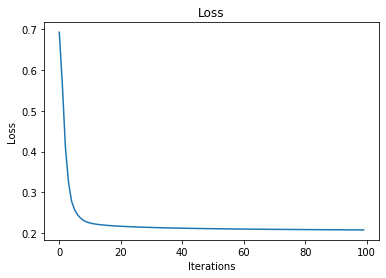

In [21]:
b, w, loss_history = train(rdd,
                           iterations=100,
                           learning_rate=10,
                           lambda_reg=0.01
                          )

plt.title('Loss')
plt.plot(np.asarray(loss_history))
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [12]:
def classify(prob, y, threshold=0.5):
    if (prob >= threshold) == y:
        return 'tp' if y==1 else 'tn'
    else:
        return 'fn' if y==1 else 'fp'
            
def evaluate(rdd, b, w, loss_history):
    
    rdd_pred = rdd.map(
        lambda x: (
            predict_probability(x[0], b, w),
            x[1]
        )
    )
    
    predictions = rdd_pred.map(
        lambda x:
            x[0]
    ).collect()
    
    corrects = rdd.map(
        lambda x:
            x[1]
    ).collect()
    
    c_m = rdd_pred.map(
        lambda x: (
            classify(x[0], x[1]),
            1
        )
    ).reduceByKey(
        lambda x, y:
            x+y
    )
    c_m = dict(c_m.collect())
    
    roc1, roc2, _ = roc_curve(corrects, predictions)
    
    results = {}
    
    results['Confusion Matrix'] = c_m
    
    results['Accuracy'] = (c_m['tp'] + c_m['tn']) \
        / (c_m['tp'] + c_m['tn'] + c_m['fp'] + c_m['fn'])
    
    results['Precision'] = c_m['tp'] / (c_m['tp'] + c_m['fp'])
    
    results['Recall'] = c_m['tp'] / (c_m['tp'] + c_m['fn'])
    
    results['Specificity'] = c_m['tn'] / (c_m['tn'] + c_m['fp'])
    
    results['F1-Score'] = 2 * results['Precision'] * results['Recall'] \
        / (results['Precision'] + results['Recall'])
    
    results['Cost Error'] = loss_history[-1]
    
    results['AUC'] = auc(roc1, roc2)
    
    results['PR-Score'] = average_precision_score(corrects, predictions)
    
    plt.title('ROC Curve')
    plt.plot(roc1, roc2, color='darkorange', 
             label='ROC curve (area %0.2f)' % results['AUC'])
    plt.plot([0, 1], [0, 1], color='navy', linestyle = '--')
    plt.legend(loc='lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    pr1, pr2, _ = precision_recall_curve(corrects, predictions)
    
    plt.title('Precision-Recall Curve')
    plt.step(pr2, pr1, color='black', alpha=0.2,
             label='PR curve (area %0.2f)' % results['PR-Score'])
    plt.fill_between(pr2, pr1, alpha=0.2, color='black')
    plt.legend(loc='lower right')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
    return(results)

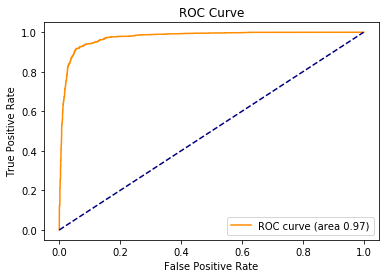

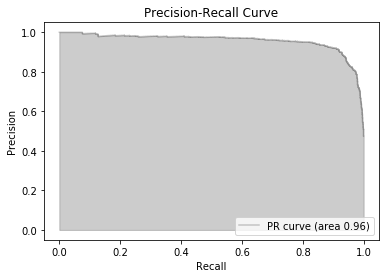

{'Confusion Matrix': {'tp': 1597, 'fn': 216, 'fp': 124, 'tn': 2664},
 'Accuracy': 0.9261030210823734,
 'Precision': 0.9279488669378269,
 'Recall': 0.8808604522890238,
 'Specificity': 0.9555236728837877,
 'F1-Score': 0.9037917374080363,
 'Cost Error': 0.21396090688389158,
 'AUC': 0.9745985078276532,
 'PR-Score': 0.9576968437110353}

In [13]:
res = evaluate(rdd, b, w, loss_history)
res